In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
from transformers import AdamW, get_linear_schedule_with_warmup
from model import SentimentClassifierUntrainedCLSMultiLastLayersMultiLinear, SentimentClassifierUntrainedCLS
from data_preprocessing import create_data_loader,\
                                tokenizer,\
                                df_train,\
                                df_dev,\
                                df_test,\
                                dev_data_loader,\
                                test_data_loader,\
                                dev_size,\
                                MAX_LEN,\
                                BATCH_SIZE,\
                                class_names

import pandas as pd
from train import DEVICE, optimizer_scheduler, train_model, train_epoch, eval_model, loss_fn
import mlflow

mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("bert-restaurant-sentiment-classification")

2024-02-26 12:22:36.546139: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-26 12:22:36.694456: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-26 12:22:37.516622: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/opt/cuda/lib64:/opt/cuda/lib:/opt/cuda/lib64:/opt/cuda/lib
2024-02-26 12:22:37.516730: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dl

<Experiment: artifact_location='/home/tung/units/python_dev/tung_aimesoft_solution/repo/codes/experiment_tracking/mlruns/1', creation_time=1708924255947, experiment_id='1', last_update_time=1708924255947, lifecycle_stage='active', name='bert-restaurant-sentiment-classification', tags={}>

In [3]:
df_train_total = pd.concat([df_train, df_dev])
total_train_data_loader = create_data_loader(df_train_total, tokenizer, MAX_LEN, BATCH_SIZE)
train_size = df_train_total.shape[0]

In [7]:
def optimizer_scheduler(model):
    
    # Optimizer Adam 
    optimizer = AdamW(model.parameters(), lr=1e-5, correct_bias=False)
    
    total_steps = len(total_train_data_loader) * EPOCHS
    
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=10,
        num_training_steps=total_steps
    )
    
    return optimizer, scheduler


In [8]:
from collections import defaultdict

EPOCHS = 3

model = SentimentClassifierUntrainedCLS(len(class_names))
model = model.to(DEVICE)
optimizer, scheduler = optimizer_scheduler(model)

with mlflow.start_run() as run:
    mlflow.set_tag("Model class", "SentimentClassifierUntrainedCLS")

    history = defaultdict(list)
    best_accuracy = 0
    best_epoch = 0
    
    for epoch in range(EPOCHS):
        
        # Show details 
        print(f"Epoch {epoch + 1}/{EPOCHS}")
        print("-" * 10)
        
        train_acc, train_loss = train_epoch(
            model,
            total_train_data_loader,
            loss_fn,
            optimizer,
            DEVICE,
            scheduler,
            train_size,
            epoch
        )
        
        print(f"Train loss {train_loss} accuracy {train_acc}")
        
        # Get model performance (accuracy and loss)
        val_acc, val_loss = eval_model(
            model,
            dev_data_loader,
            loss_fn,
            DEVICE,
            dev_size
        )
        
        print(f"Test   loss {val_loss} accuracy {val_acc}")
        print()
        
        
        mlflow.log_metric("Train Loss", train_loss, step=epoch)
        mlflow.log_metric("Test  Loss", val_loss, step=epoch)
        mlflow.log_metric("Train Accuracy", train_acc, step=epoch)
        mlflow.log_metric("Test Accuracy", val_acc, step=epoch)

        
        history['train_acc'].append(train_acc)
        history['train_loss'].append(train_loss)
        history['val_acc'].append(val_acc)
        history['val_loss'].append(val_loss)
        
    mlflow.pytorch.log_model(
        model, artifact_path="final_model"
    )
                


Epoch 1/3
----------
Train loss 0.4458996044022256 accuracy 0.7511111111111111
Test   loss 0.0477471724152565 accuracy 0.995

Epoch 2/3
----------
Train loss 0.12443363559352041 accuracy 0.9544444444444444
Test   loss 0.011975505356011646 accuracy 0.995

Epoch 3/3
----------
Train loss 0.024628276141874236 accuracy 0.9933333333333333
Test   loss 0.004843222709106547 accuracy 1.0



In [9]:
print(f"run id = {run.info.run_id}")

run id = 9e19439b289c4b9db8fec6137f47eb2c


# Inference on test set

## Load model

In [10]:
import mlflow

run_id = "9e19439b289c4b9db8fec6137f47eb2c"
model_path = "final_model"

mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("bert-restaurant-sentiment-classification")

model_uri = f"runs:/{run_id}/{model_path}"
loaded_model = mlflow.pytorch.load_model(model_uri)



In [17]:
from train import eval_model, loss_fn, DEVICE
from data_preprocessing import test_data_loader, df_test


acc, loss = eval_model(loaded_model, test_data_loader, loss_fn, DEVICE, len(df_test))
print(acc.item(), loss)

0.96 0.09963598613103386


# Confusion matrix

In [12]:
from inference import get_predictions

def roc_curve_plot(model, data_loader, DEVICE):

    y_texts, y_pred, y_pred_probs, y_test = get_predictions(
        loaded_model,
        data_loader,
        DEVICE
    )
    

In [13]:
from sklearn.metrics import confusion_matrix, classification_report

y_texts, y_pred, y_pred_probs, y_test = get_predictions(
        loaded_model,
        test_data_loader,
        DEVICE
    )
    

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


Accuracy: 0.9600
              precision    recall  f1-score   support

           0       0.98      0.94      0.96        50
           1       0.94      0.98      0.96        50

    accuracy                           0.96       100
   macro avg       0.96      0.96      0.96       100
weighted avg       0.96      0.96      0.96       100

[[47  3]
 [ 1 49]]


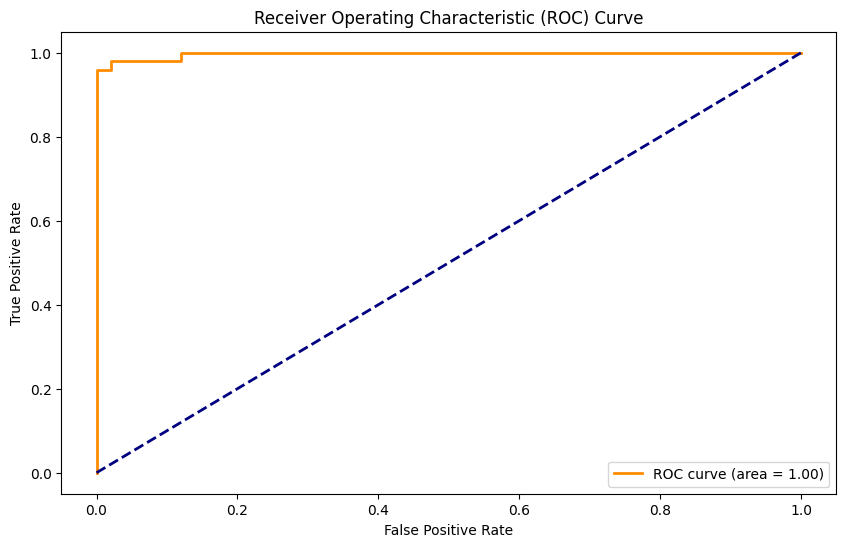

In [14]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, _ = roc_curve(y_test, y_pred_probs[:,1])
roc_auc = auc(fpr, tpr)


# Plot ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


In [21]:
# Show errors
import numpy as np
pd.set_option('display.max_colwidth', None)

errors = np.where(y_test != y_pred)
error_df = pd.DataFrame({"text": y_texts, "pred": y_pred, "label": y_test, "prob": y_pred_probs[:,1]})
error_df.loc[errors]

,text,pred,label,prob
31,"The shower area is outside so you can only rinse, not take a full shower, unless you don't mind being nude for everyone to see!",1,0,0.955171
35,Con: spotty service.,1,0,0.877485
39,"After one bite, I was hooked.",0,1,0.014045
89,"If the food isn't bad enough for you, then enjoy dealing with the world's worst/annoying drunk people.",1,0,0.932930


It shows that the models can't get sacarsm (If the food **isn't bad** enough for you), or doesn't get the full context (**hooked** can be mistaked as an attack !?)